In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import misc
from scipy.optimize import curve_fit
import seaborn as sns
from IPython.display import display, HTML

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import impute
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('C:/Users/lukep/Documents/big_data/powerlifting.csv')
df = df[['Sex', 'Age', 'Equipment', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']]
df = df.dropna(subset=['Sex', 'Age', 'Equipment', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg'])
df = df[(df['Best3SquatKg']>0) & (df['Best3BenchKg']>0) & (df['Best3DeadliftKg']>0)]
lb_sex = LabelEncoder() 
lb_equip = LabelEncoder() 
df['Sex'] = lb_sex.fit_transform(df['Sex'])
df['Equipment'] = lb_equip.fit_transform(df['Equipment'])
df.sort_index(inplace=True)

C:\Users\lukep\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(list(lb_sex.inverse_transform([0,1])))
print(list(lb_equip.inverse_transform([0,1,2,3])))

['F', 'M']
['Multi-ply', 'Raw', 'Single-ply', 'Wraps']


In [4]:
df.head()

,Sex,Age,Equipment,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg
0,0,29.0,3,59.8,105.0,55.0,130.0
1,0,29.0,3,58.5,120.0,67.5,145.0
3,0,23.0,3,60.0,105.0,72.5,132.5
4,0,45.0,3,104.0,140.0,80.0,170.0
5,0,37.0,3,74.0,142.5,82.5,145.0


Perform stratified sampling

In [5]:
df['deadlift_cat'] = np.ceil((3/200)*df['Best3DeadliftKg']-1/2)
df['deadlift_cat'].where(df['deadlift_cat'] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['deadlift_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set= df.iloc[test_index]

Seperate data from predictors

In [6]:
X = strat_train_set[['Best3DeadliftKg', 'Best3BenchKg']].values
y = strat_train_set['Equipment'].copy()
X=X[(y==0)|(y==1)][0:1000]
y=y[(y==0)|(y==1)][0:1000]

Plot data.

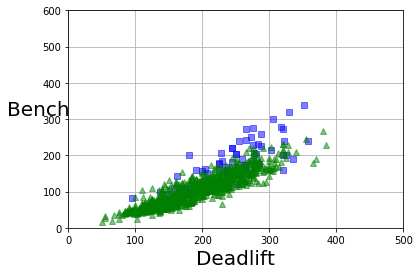

In [11]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", alpha=0.5, label='Multi-ply')
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", alpha=0.5, label='Raw')
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"Deadlift", fontsize=20)
    plt.ylabel(r"Bench", fontsize=20, rotation=0)

plot_dataset(X, y, [0, 500, 0, 600])
plt.show()

# Machine Learning

Use pipeline to get to appropriate data format

In [27]:
from sklearn.svm import SVC
poly_kernel_svm_clf_deg2 = Pipeline((
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=2, coef0=1, C=5))
    ))
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=10))
    ])

In [28]:
poly_kernel_svm_clf_deg2.fit(X,y)
rbf_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

Text(0.5, 1.0, '$\\gamma=5$,$C=0.001$')

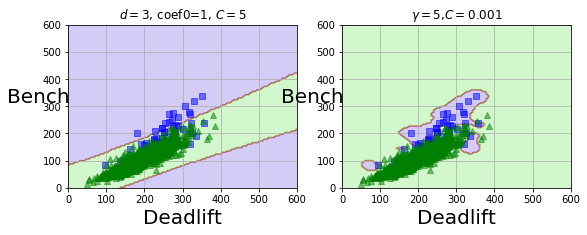

In [29]:
def plot_predictions(clf, lims):
    # Arrays of points we want to predict
    x0s = np.linspace(lims[0], lims[1], 100)
    x1s = np.linspace(lims[2], lims[3], 100)
    # Form into meshgrid
    x0, x1 = np.meshgrid(x0s, x1s)
    # Form into array where each element is (x1,x2)
    X = np.c_[x0.ravel(), x1.ravel()]
    # Make predictions based on data
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_predictions(poly_kernel_svm_clf_deg2, [0, 600, 0, 600])
plot_dataset(X, y, [0, 600, 0, 600])
plt.title('$d=3$, coef0=1, $C=5$')
plt.subplot(122)
plot_predictions(rbf_kernel_svm_clf, [0, 600, 0, 600])
plot_dataset(X, y, [0, 600, 0, 600])
plt.title('$\gamma=5$,$C=0.001$')